In [1]:
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import decimal
import networkx as nx
%matplotlib inline

## simple case of stability and reliability:

The mean community biomass is $m$ and number of species is $k$, each with biomass $\frac{m}{k}$ and no covariance. Following Tilman *et al* 1998, individual species biomass variances ($\sigma^2_i$) are calculated $\sigma^2_i = cm^z_i$, where $c$ is a constant and $m_i$ is the mean biomass of species $i$. Therefore, community biomass variance can be derived: $\sigma^2 = cm^zk^{1-z}$

In [2]:
m = 100 # m, mean community biomass
threshold = 79 # the number we don't want to go below

In [3]:
k = 10 # k, number of species in our community
timelength = 300 # length of our time series... eg years?
lins=np.linspace(0,timelength,timelength*10) # make the x values on which we'll calculate y values
c = .5 # percent of expectation that is variance (these scale together)
z = 1 # relationship between mean and variance

In [4]:
# community variance from tilman etal 1998, pp279 for identical abundances and no covariation
comm_var = c*(m**z)*k**(1-z)
comm_var

50.0

Suppose we want to know when we would expect to have first crossed a certain threshold of community biomass, $m_{thresh}$.

Given the community mean biomass and variance, we can evaluate the probability of observing a community biomass value $m_t$ at time $t$. The probability that the value of $m_t$ is greater than $m_{thresh}$ is evaluated using $P[x < \frac{m_{thresh} - m}{\sigma}]$ on the standard normal distribution.

In [5]:
# get the probability of reaching the threshold at each time point
probs = np.array([st.norm.cdf((threshold - m) / np.sqrt(comm_var)) for i in range(len(lins))])
# get the log of the 1-probs for each time point
log_noevent_probs = np.array([(decimal.Decimal(1)-decimal.Decimal(i)).ln() for i in probs])

counter = decimal.Decimal(0)
reliability_probs = np.zeros(log_noevent_probs.shape)
for i in range(len(reliability_probs)):
    counter += log_noevent_probs[i]
    reliability_probs[i] = counter.exp()


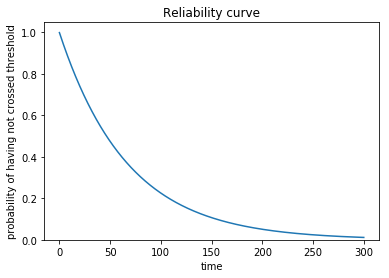

In [6]:
ax = sns.lineplot(lins,reliability_probs);
ax.set_title('Reliability curve')
ax.set_ylabel('probability of having not crossed threshold');
ax.set_xlabel('time');
ax.set_ylim(0,);

This curve tells us that there is a 50% chance of having crossed our threshold around time = 50.

### Showing this numerically, with independent white noise

We're generating individual species biomasses through time using the deterministic expectation for each with uncorrelated normal distribution draws thrown on top. Note that this disregards the fact that white noise is probably correlated through time...

In [7]:
num_tests = 5000 # number of communities to simulate

# array to store rows -- each column will indicate whether threshold has
# been crossed yet by that time.
thresh_crossing_probs = np.zeros((num_tests,len(lins))) 

# for each community...
for i in range(num_tests):
    # we'll later change cells to zero after the point where threshold is crossed
    thresh_record = np.ones((len(lins)),dtype=bool)
    # get biomasses through time for each species
    species_biomasses = m/k + np.random.normal(0,np.sqrt(c*(m/k)**z),(k,len(lins)))
    # sum the species biomasses through time
    community_biomass = np.sum(species_biomasses,axis=0)
    # find where the threshold is crossed
    thresh_crosses = np.where(community_biomass < threshold)[0]
    # if the threshold was crossed...
    if len(thresh_crosses):
        # set everything after the cross point to zero.
        thresh_record[np.min(thresh_crosses):] = False
    # save row into big array
    thresh_crossing_probs[i] = thresh_record

In [8]:
# sum rows of big array and normalize -- columns with bigger numbers
# represent columns that had more "true" values, ie before threshold was reached
results = np.sum(thresh_crossing_probs,axis=0) / num_tests

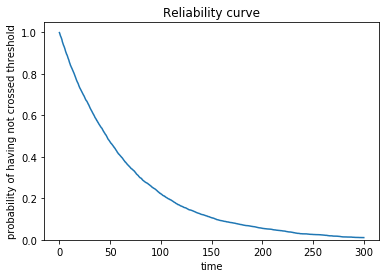

In [9]:
ax = sns.lineplot(lins,results);
ax.set_title('Reliability curve')
ax.set_ylabel('probability of having not crossed threshold');
ax.set_xlabel('time');
ax.set_ylim(0,);

This looks like the analytical expecation. Good!

It would be nice to supplement this with numerical simulations: simulating each individual species biomass trajectory, summing up all of these trajectories, and recording when the threshold is crossed. 

Simulating individual species trajectories is hard, assuming we aren't just "throwing down" noise onto a mean but are instead using a stochastic process model (continuous-time markov chain). Stochastic differential equations literature might help with that. 

### Moving beyond independent white noise

Noise is better represented in this system as a moving average process -- something that allows correlation between noise at nearby time points but that allows a constant variance through time. Ie, we don't think the variance around mean biomass is going to change wildly through time -- it should just fluctuate in a markov-like way so that nearby values are correlated but the mean holds.